# Libraries and Data Information

In [1]:
import numpy as np 
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import norm, skew, boxcox

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# warning 
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/autompg-dataset/auto-mpg.csv


**mpg:** The "mpg" column represents the miles per gallon, indicating how many miles a vehicle can travel on one gallon of fuel. "mpg" is our target variable.

**cylinders:** The "cylinders" column denotes the number of cylinders in the engine of the vehicle. It is a multi-valued discrete feature, indicating the count of cylinders, such as 3, 4, 5, 6, 8.

**displacement:** The "displacement" column represents the total volume swept by all the cylinders in the engine. It is a continuous value and is typically measured in liters.

**horsepower:** The "horsepower" column indicates the power output of the vehicle's engine. It is a continuous value, representing the strength of the engine.

**weight:** The "weight" column represents the weight of the vehicle. It is a continuous value, often measured in pounds or kilograms.

**acceleration:** The "acceleration" column denotes the time it takes for the vehicle to reach a certain speed. It is a continuous value, indicating the rate of change of velocity.

**model year:** The "model year" column represents the year in which the vehicle was manufactured. It is a multi-valued discrete feature, indicating different years of production.

**origin:** The "origin" column indicates the geographic origin or manufacturing region of the vehicle. It is a multi-valued discrete feature, representing different countries or regions.

**car name:** The "car name" column specifies the unique name of each vehicle instance. It is a string feature, providing a distinct identifier for each car

# Read and Check Data

In [13]:
df = pd.read_csv("/kaggle/input/autompg-dataset/auto-mpg.csv")
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


* Horsepower column is object type, probably because of string expressions in this form. Normally it is expected to be a numeric column.
* Let's examine it first and then apply numeric column transformation

In [15]:
df.horsepower.unique()

array(['130', '165', '150', '140', '198', '220', '215', '225', '190',
       '170', '160', '95', '97', '85', '88', '46', '87', '90', '113',
       '200', '210', '193', '?', '100', '105', '175', '153', '180', '110',
       '72', '86', '70', '76', '65', '69', '60', '80', '54', '208', '155',
       '112', '92', '145', '137', '158', '167', '94', '107', '230', '49',
       '75', '91', '122', '67', '83', '78', '52', '61', '93', '148',
       '129', '96', '71', '98', '115', '53', '81', '79', '120', '152',
       '102', '108', '68', '58', '149', '89', '63', '48', '66', '139',
       '103', '125', '133', '138', '135', '142', '77', '62', '132', '84',
       '64', '74', '116', '82'], dtype=object)

* Missing values are filled with a question mark, therefore object type
* let's perform the necessary operations on the missing data analysis

## Miising Value Analysis

In [16]:
# Replace "?" symbols with NaN
df['horsepower'].replace('?', np.nan, inplace=True)

# Convert the column to float type
df['horsepower'] = df['horsepower'].astype(float)

In [17]:
df[df.isnull().any(axis=1)]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
32,25.0,4,98.0,NaN,2046,19.0,71,1,ford pinto
126,21.0,6,200.0,NaN,2875,17.0,74,1,ford maverick
330,40.9,4,85.0,NaN,1835,17.3,80,2,renault lecar deluxe
336,23.6,4,140.0,NaN,2905,14.3,80,1,ford mustang cobra
354,34.5,4,100.0,NaN,2320,15.8,81,2,renault 18i
374,23.0,4,151.0,NaN,3035,20.5,82,1,amc concord dl


In [18]:
# The common point between the vehicles seems to be the cylinder
df[df.cylinders == 4]["horsepower"].mean().round()

78.0

In [19]:
# The brand of 3 vehicles is ford
ford_4 = df[(df.cylinders == 4) & (df["car name"].str.contains("ford"))]["horsepower"].mean().round()
ford_4

81.0

In [20]:
# horsepower average
df["horsepower"].mean().round()

104.0

* As seen above, if we fill in the missing values with the average, we enter a high value. For this reason, we decided to fill it with the ford_4 value we obtained from the cylinder and brand feature

In [21]:
# Fill NaN values with the ford_4 
df['horsepower'].fillna(ford_4, inplace=True)

In [22]:
df.horsepower.isnull().sum()

0

In [23]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
mpg,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6
cylinders,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
displacement,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
horsepower,398.0,104.115578,38.306358,46.0,76.000,92.0,125.000,230.0
weight,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
acceleration,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
model year,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0
origin,398.0,1.572864,0.802055,1.0,1.000,1.0,2.000,3.0


In [26]:
# Let's create a more detailed table for our features

# Create an empty list to store the output data
output_data = []

for col in df.columns:
    
    # If the number of unique values in the column is less than or equal to 5
    if df.loc[:, col].nunique() <= 5:
        # Get the unique values in the column
        unique_values = df.loc[:, col].unique()
        # Append the column name, number of unique values, unique values, and data type to the output data
        output_data.append([col, df.loc[:, col].nunique(), unique_values, df.loc[:, col].dtype])
    else:
        # Otherwise, append only the column name, number of unique values, and data type to the output data
        output_data.append([col, df.loc[:, col].nunique(),"-", df.loc[:, col].dtype])

output_df = pd.DataFrame(output_data, columns=['Column Name', 'Number of Unique Values', ' Unique Values ', 'Data Type'])

output_df

,Column Name,Number of Unique Values,Unique Values,Data Type
0,mpg,129,-,float64
1,cylinders,5,"[8, 4, 6, 3, 5]",int64
2,displacement,82,-,float64
3,horsepower,93,-,float64
4,weight,351,-,int64
5,acceleration,95,-,float64
6,model year,13,-,int64
7,origin,3,"[1, 3, 2]",int64
8,car name,305,-,object


# Correlation Analysis

* A **heatmap** is a simple heatmap that visualizes a correlation matrix using a color scale. 
* **Clustermap** is an enhanced version of a heatmap and is used both to show correlations and to highlight clusters in the dataset.

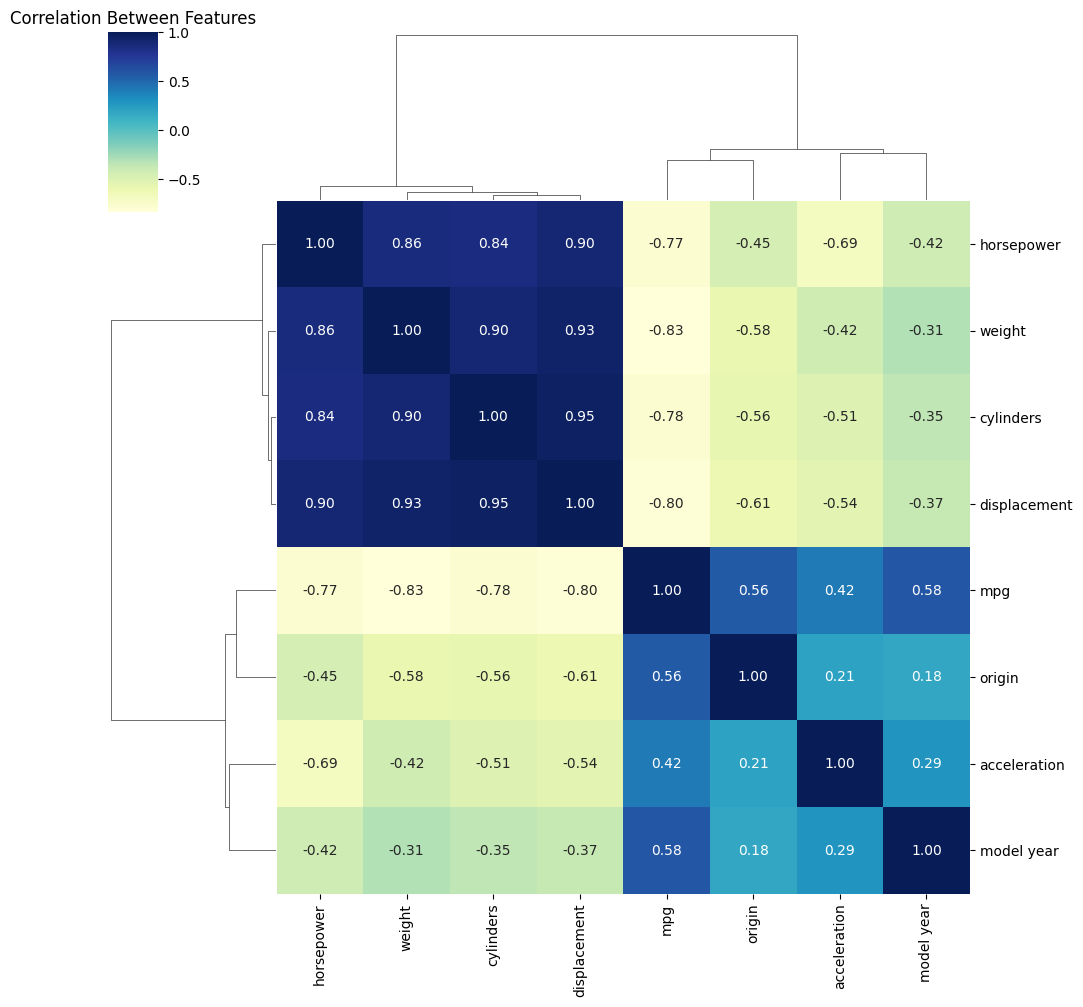

In [27]:
sns.clustermap(df.corr(), annot = True, fmt = ".2f", cmap='YlGnBu')
plt.title("Correlation Between Features")
plt.show()

* In the chart above we can observe both positive and negative correlations that are highly correlated
* By setting a threshold value according to the target variable, we can select features and narrow the above graph or use it to draw other graphs

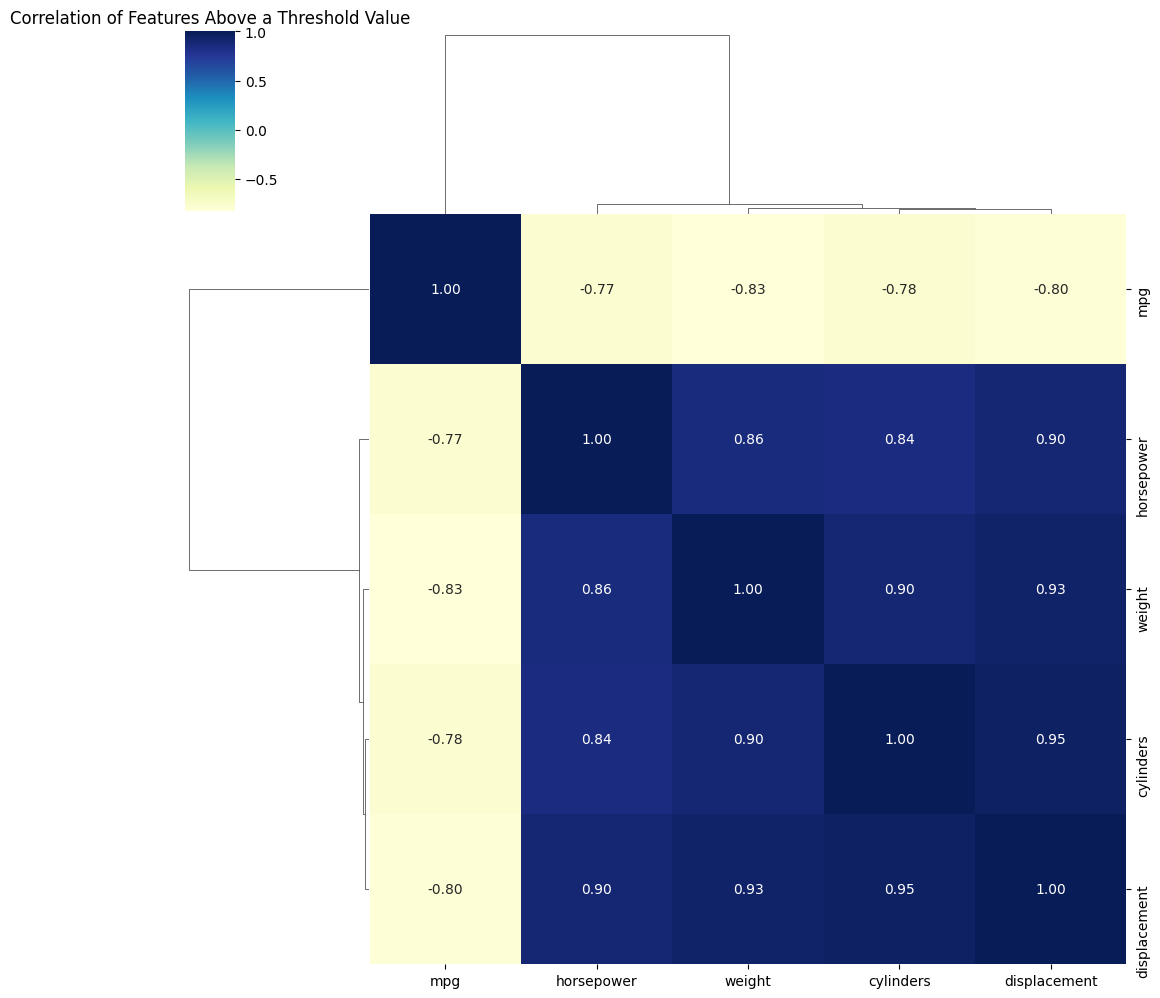

In [28]:
threshold = 0.75
filtre = np.abs(df.corr()["mpg"])>threshold
corr_features = df.corr().columns[filtre].tolist()
sns.clustermap(df[corr_features].corr(), annot = True, fmt = ".2f", cmap='YlGnBu')
plt.title("Correlation of Features Above a Threshold Value")
plt.show()

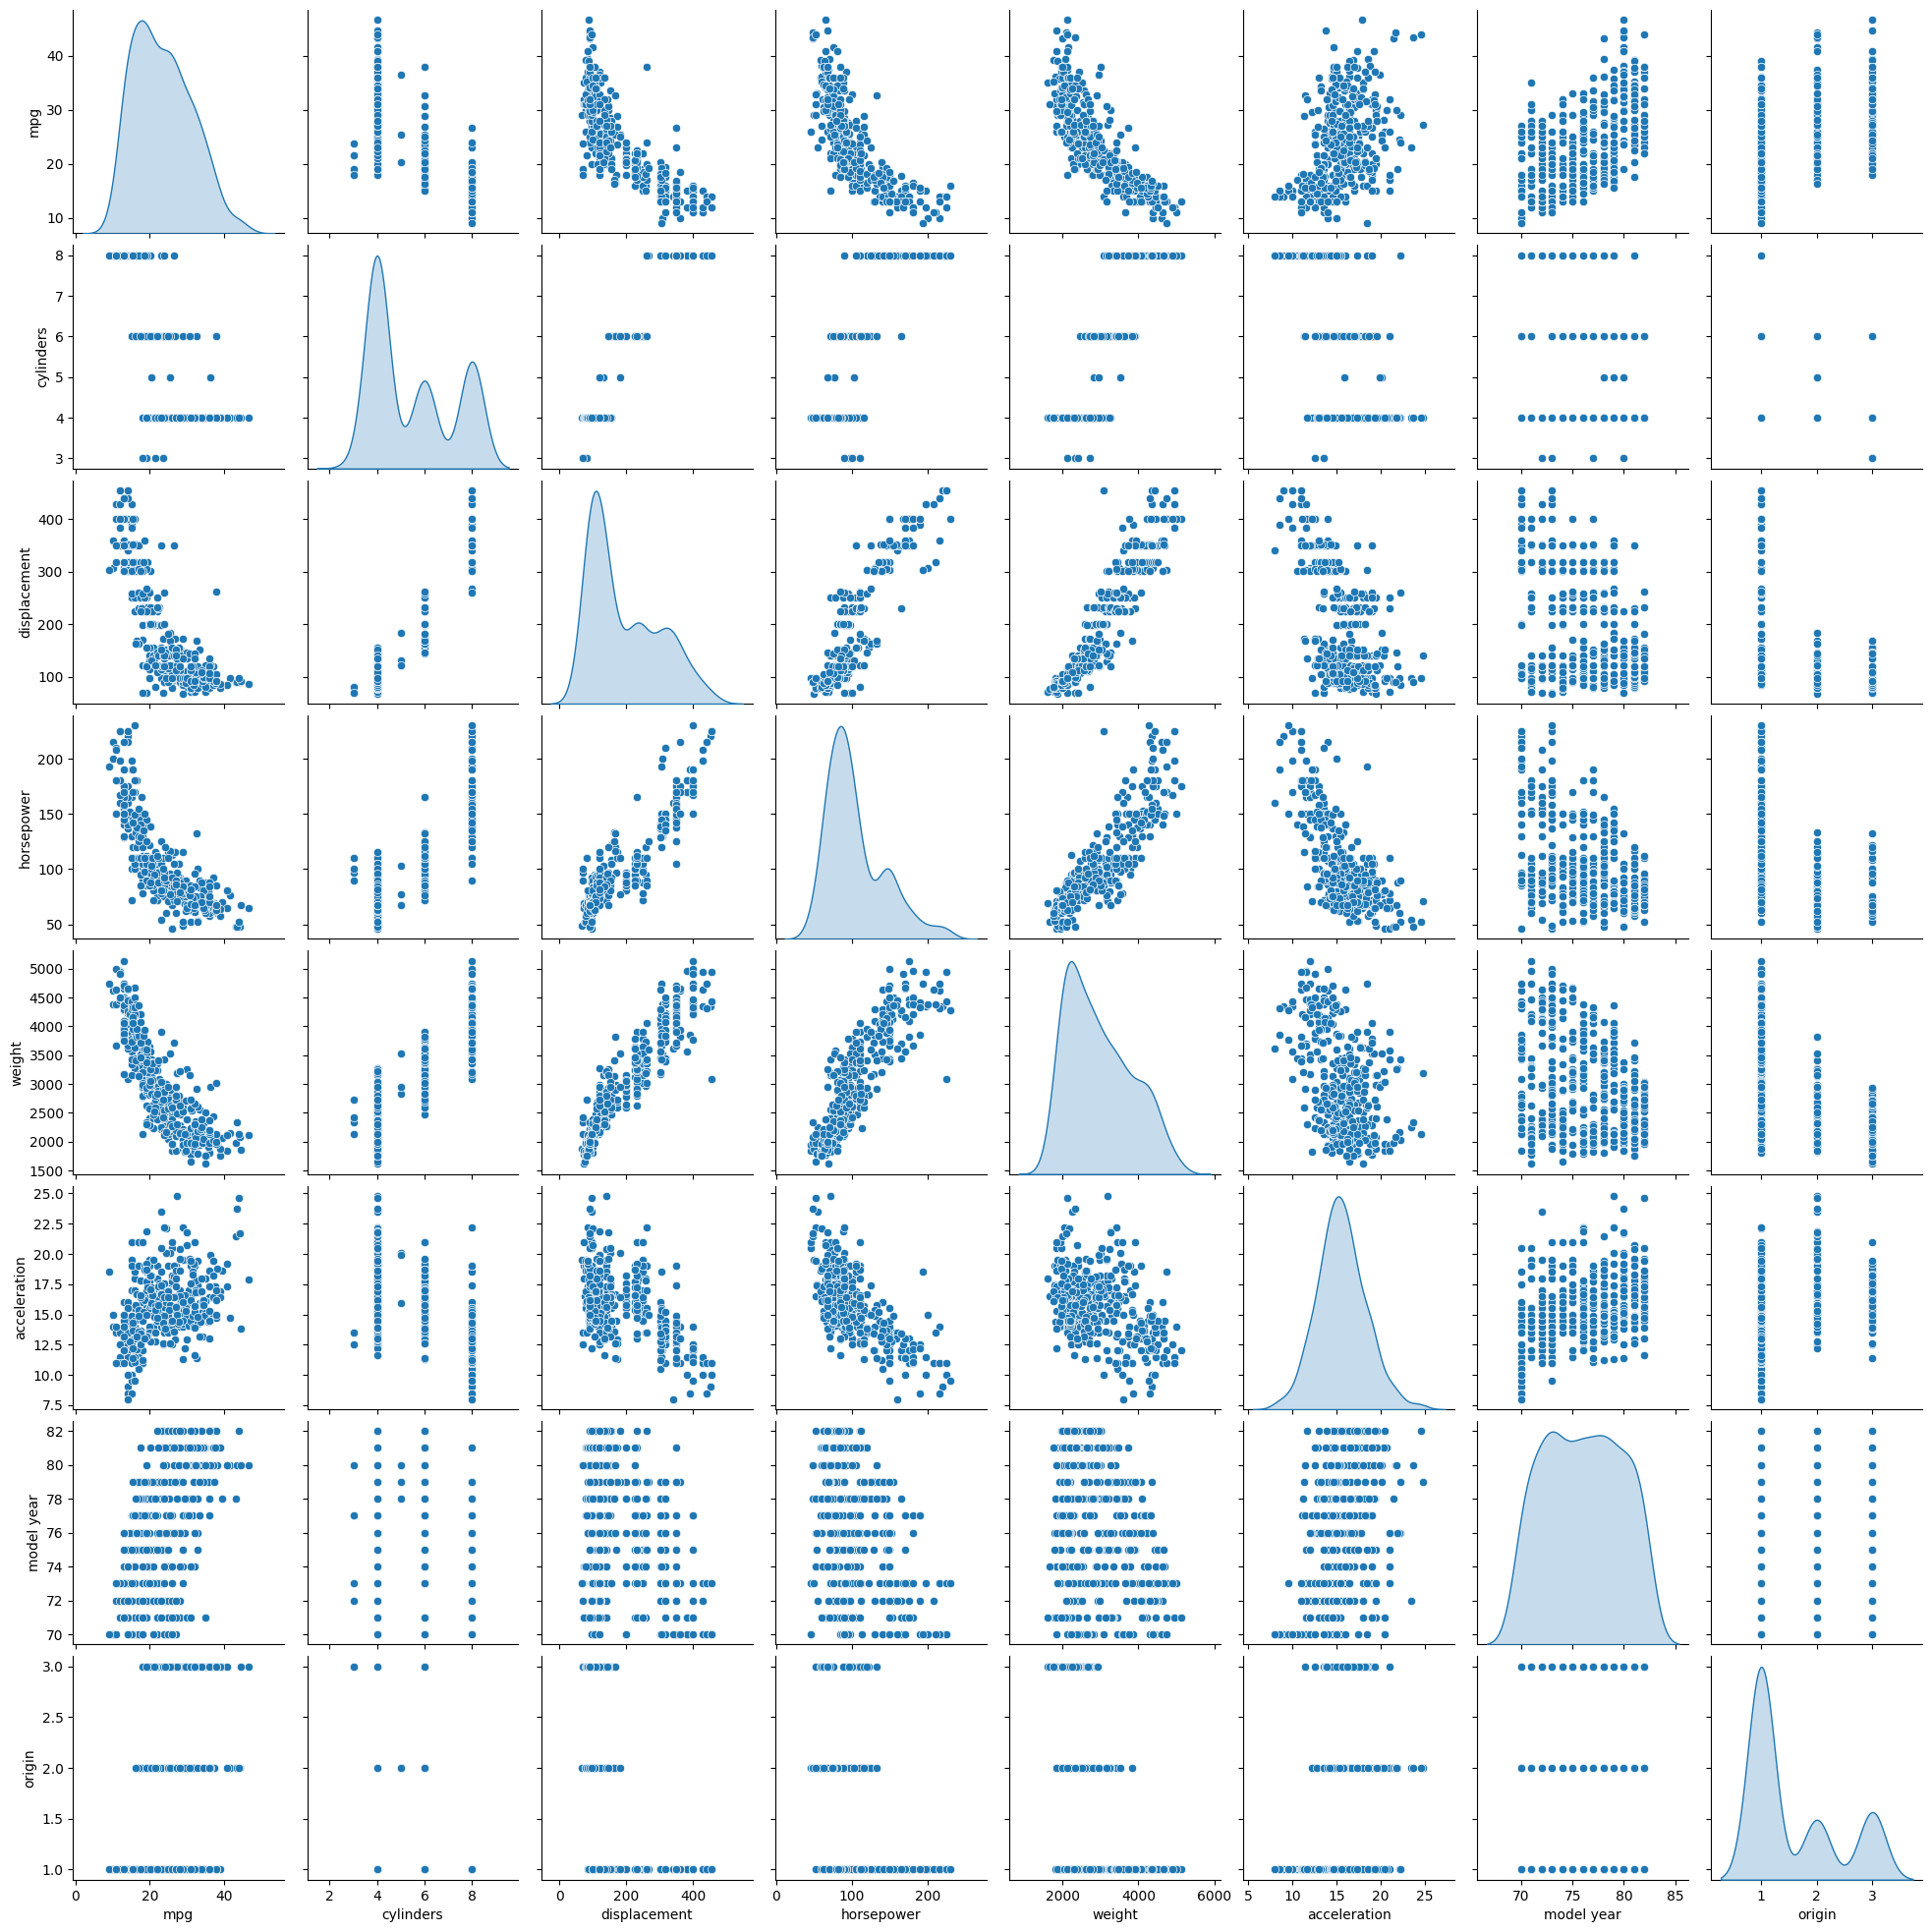

In [29]:
sns.pairplot(df, diag_kind = "kde");

* The similarity between the 3 columns('displacement', 'horsepower', 'weight') in the chart above draws attention in terms of multicollinearity 
* Since the 'cylinders' and 'origin' columns mostly have 3 values, we can consider them as categorical data. So we can do categorical transformation in feature engineering

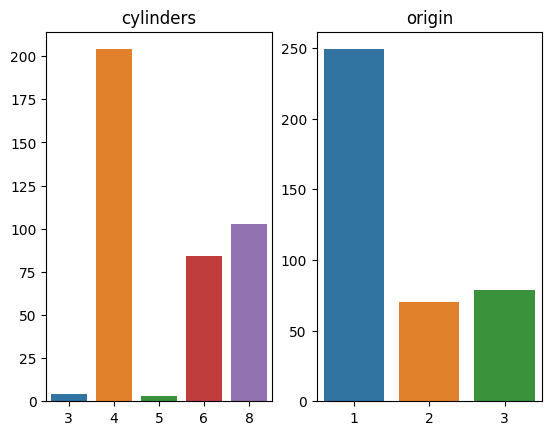

In [30]:
# Let's observe the categorical status of the columns 'cylinders' and 'origin'

plt.subplot(121)
sns.barplot(x = df["cylinders"].value_counts().index, y = df["cylinders"].value_counts().values)
plt.title("cylinders")
plt.subplot(122)
sns.barplot(x = df["origin"].value_counts().index, y = df["origin"].value_counts().values)
plt.title("origin")
plt.show()

# Features & Target Variable Relationship

* Considering the brand of the cars, it appears that a car with label 1 is manufactured in America, label 2 corresponds to a car made in Europe, and label 3 represents a car produced in Asia or another part of the world.

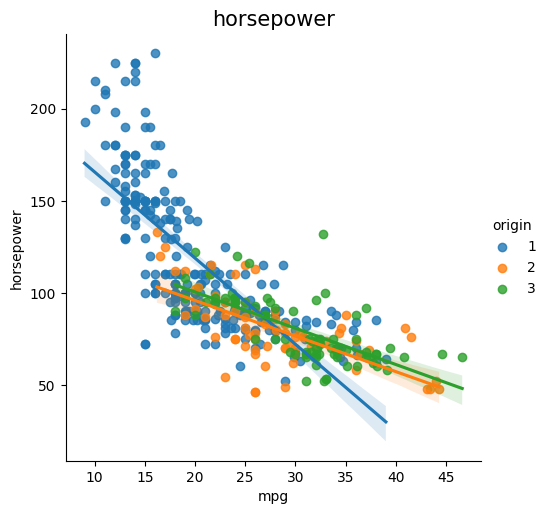

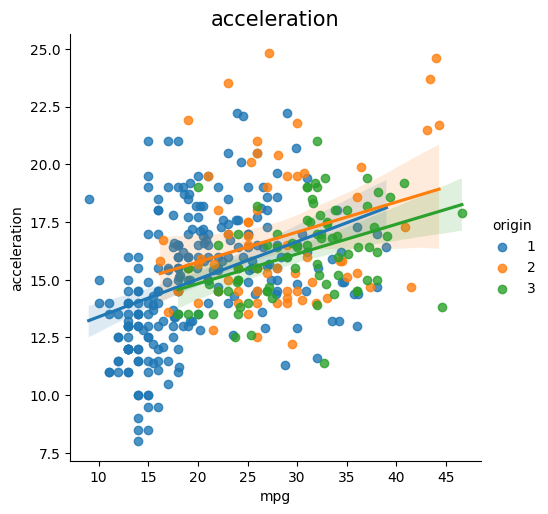

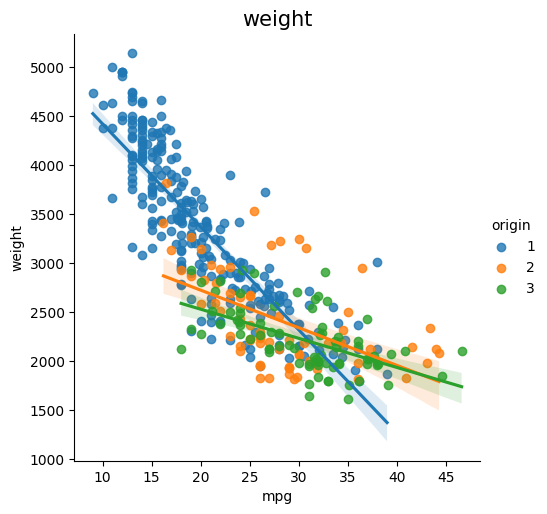

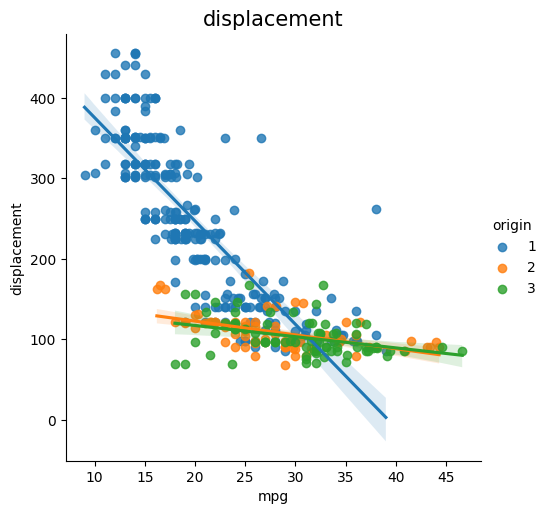

In [31]:
for i in ["horsepower","acceleration","weight","displacement"]:
    plot = sns.lmplot(x = "mpg", y = i, data = df, hue = 'origin')
    plt.title(i, fontsize = 15)
    plt.show()

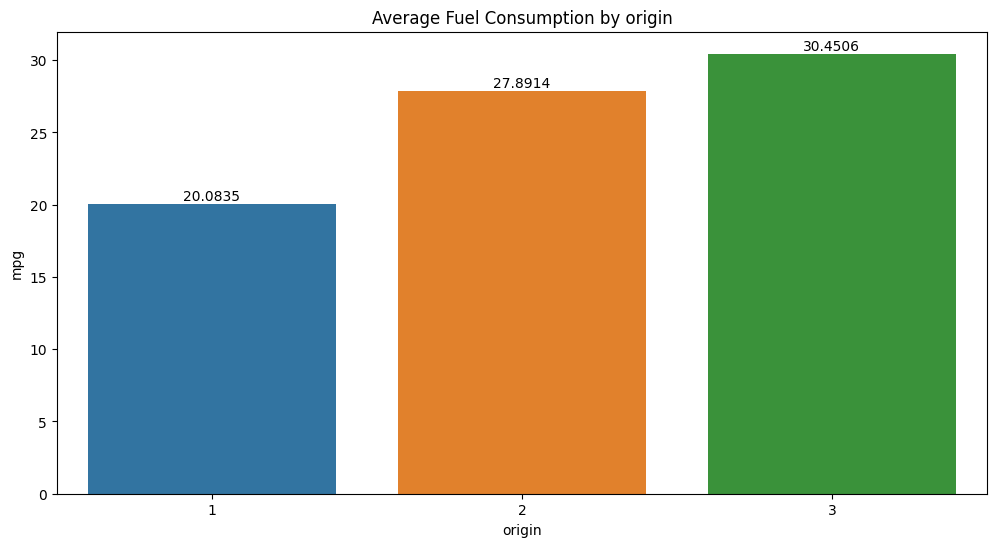

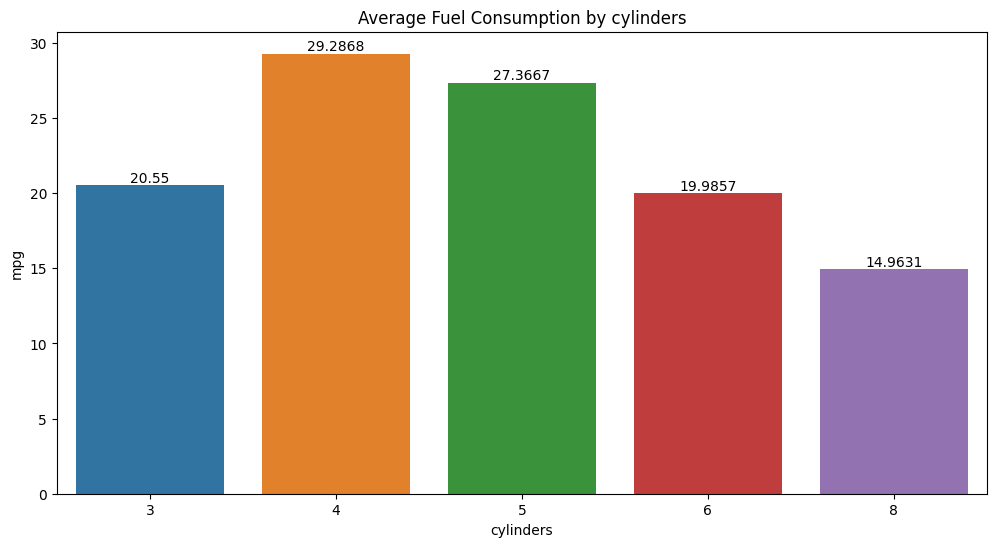

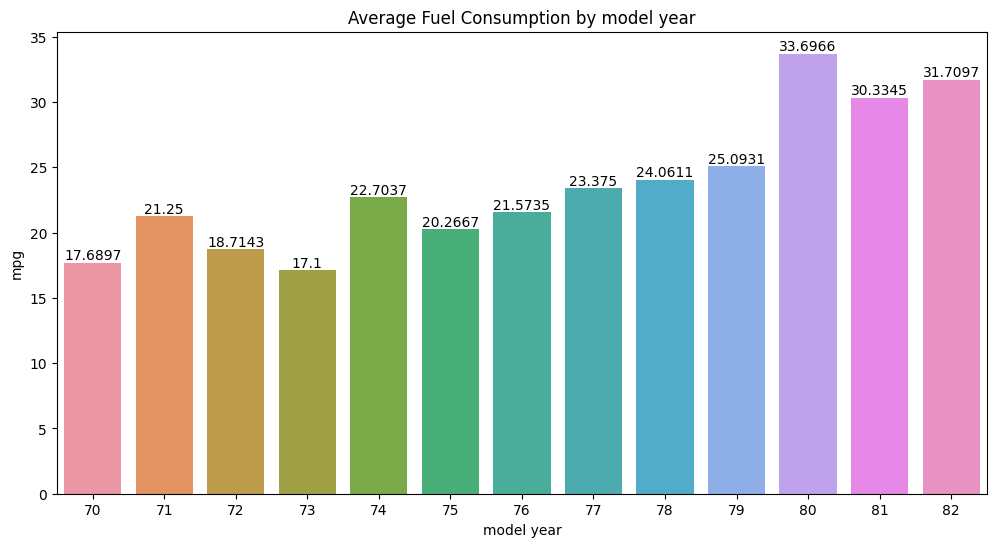

In [32]:
for i in ["origin", "cylinders", "model year"]:

    cat_mpg = df.groupby(i)["mpg"].mean()

    plt.figure(figsize = (12,6))
    ax = sns.barplot(x = cat_mpg.index, y = cat_mpg)
    plt.title(f"Average Fuel Consumption by {i}")
    ax.bar_label(ax.containers[0])
    plt.show()

# Outlier Analysis

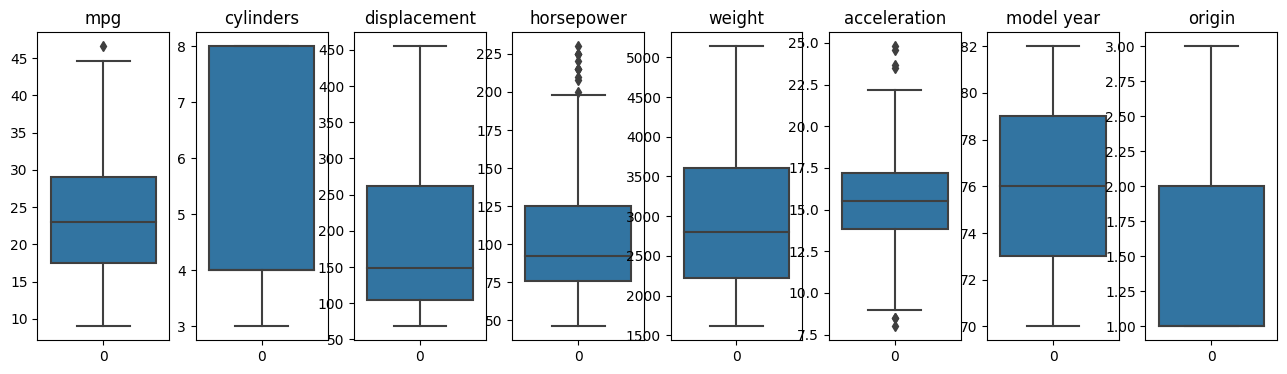

In [33]:
x = 0
plt.figure(figsize=(16, 4))
for i in df.select_dtypes("number"):
    x += 1
    plt.subplot(1, 8, x)
    sns.boxplot(data=df[i])
    plt.title(i)
    
plt.show()

* 'horsepower' and 'acceleration' columns have outliers 

In [34]:
df.describe()["horsepower"]

count    398.000000
mean     104.115578
std       38.306358
min       46.000000
25%       76.000000
50%       92.000000
75%      125.000000
max      230.000000
Name: horsepower, dtype: float64

In [35]:
# number of rows before outlier analysis
df.shape

(398, 9)

In [36]:
# manual method for outlier analysis 
# horsepower

thr = 2
horsepower_desc = df.describe()["horsepower"]
q3_hp = horsepower_desc[6]
q1_hp = horsepower_desc[4]
IQR_hp = q3_hp - q1_hp
top_limit_hp = q3_hp + thr*IQR_hp
bottom_limit_hp = q1_hp - thr*IQR_hp

filter_hp = (bottom_limit_hp < df["horsepower"]) & (df["horsepower"] < top_limit_hp)

df = df[filter_hp]
df.shape

(394, 9)

In [37]:
# acceleration

acceleration_desc = df.describe()["acceleration"]
q3_acc = acceleration_desc[6]
q1_acc = acceleration_desc[4]
IQR_acc = q3_acc - q1_acc 
top_limit_acc = q3_acc + thr*IQR_acc
bottom_limit_acc = q1_acc - thr*IQR_acc

filter_acc = (bottom_limit_acc < df["acceleration"]) & (df["acceleration"] < top_limit_acc)

df = df[filter_acc]
df.shape

(391, 9)

* 4 rows from the horsepower column analysis and 3 rows from the acceleration column analysis were identified as outliers and these rows were removed from the data

# Measures of Skewness( Distributions )

In [38]:
# let's look at the skewed values of the features. Positive skewed if greater than one, negative skewed if less than minus one. 
# if skewed is close to zero, the distribution is considered relatively symmetric.

skewed_features = df.select_dtypes("number").apply(lambda x: pd.Series.skew(x)).sort_values(ascending=False)
skewness = pd.DataFrame(skewed_features, columns=["skewed"])
skewness

,skewed
horsepower,1.023858
origin,0.918675
displacement,0.695176
cylinders,0.541499
weight,0.532211
mpg,0.422079
acceleration,0.145123
model year,0.010803


* As can be seen from the table above, there are not very high skewed values. However, if there were high values, we could use Logarithmic Transformation, Square Root Transformation or Box-Cox Transformation 
* Let's try a few methods to see the change 

In [39]:
# select the columns to process (we did not select the categorical and low skewed ones )

df_skewed = df[['mpg', 'displacement', 'horsepower', 'weight']]

In [40]:
df_skewed

,mpg,displacement,horsepower,weight
0,18.0,307.0,130.0,3504
1,15.0,350.0,165.0,3693
2,18.0,318.0,150.0,3436
3,16.0,304.0,150.0,3433
4,17.0,302.0,140.0,3449
...,...,...,...,...
392,27.0,151.0,90.0,2950
393,27.0,140.0,86.0,2790
395,32.0,135.0,84.0,2295
396,28.0,120.0,79.0,2625


* Note: we can look at the distribution with a histogram as well as with a probability plot( stats.probplot )

mpg: 
mu(mean): 23.499232736572893, 
sigma(std): 7.678599778082707


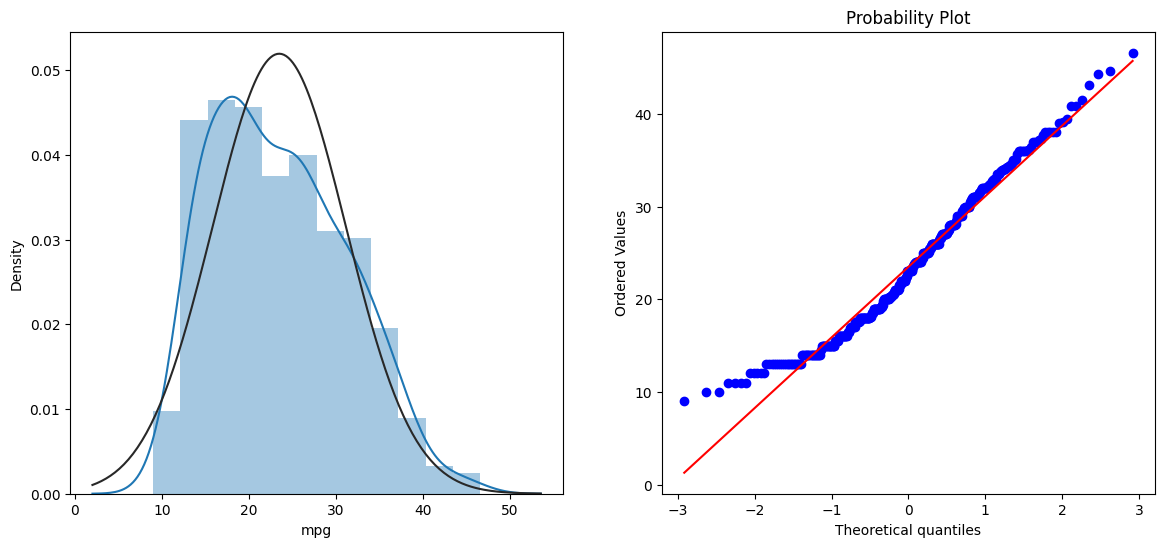

displacement: 
mu(mean): 191.53580562659846, 
sigma(std): 101.70147125308219


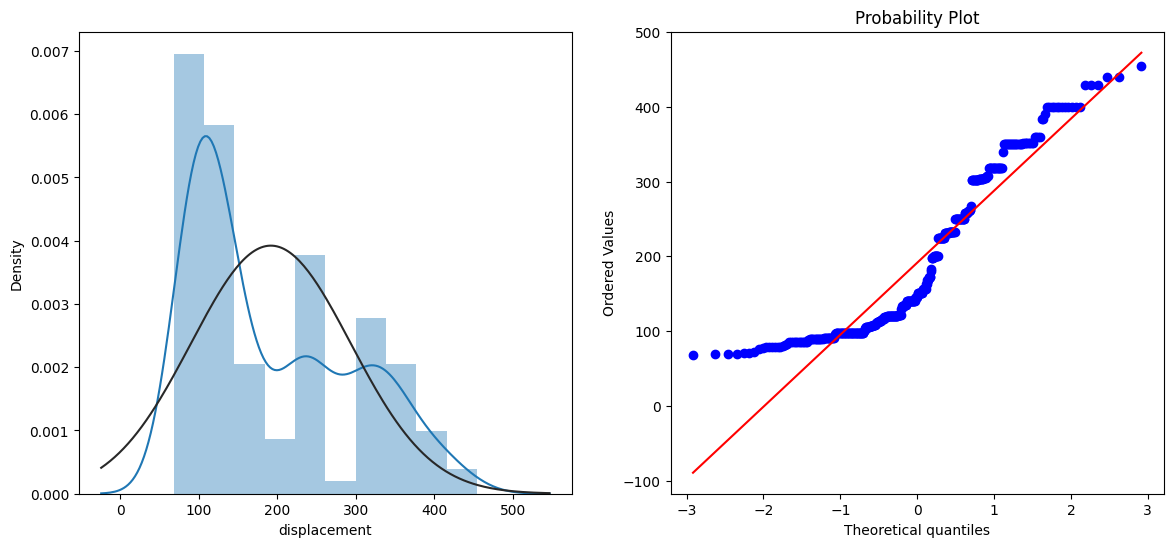

horsepower: 
mu(mean): 103.22762148337596, 
sigma(std): 36.31324156927456


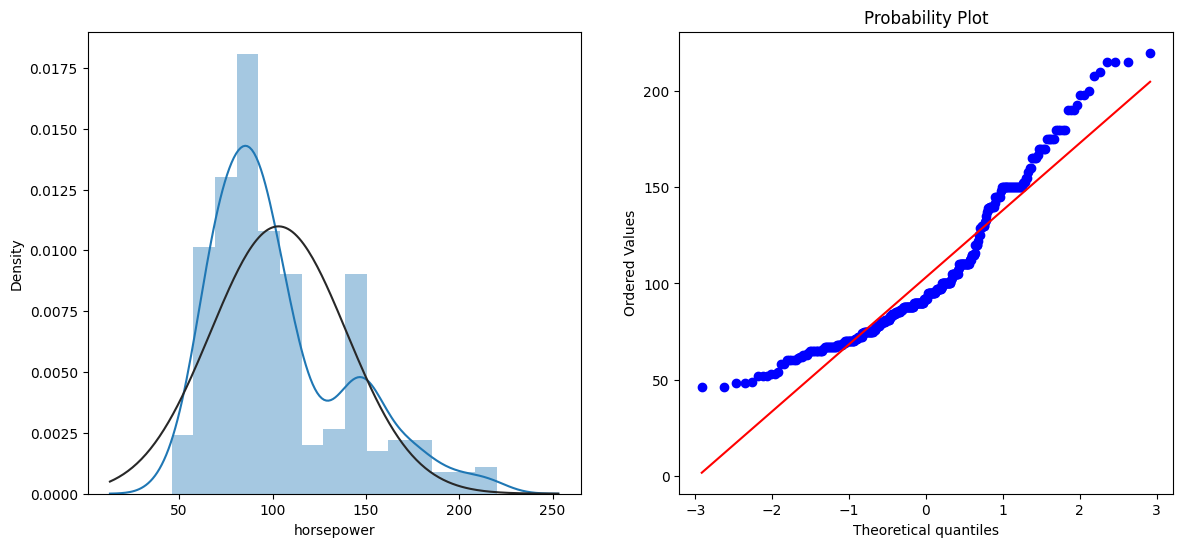

weight: 
mu(mean): 2961.2122762148338, 
sigma(std): 839.790376019469


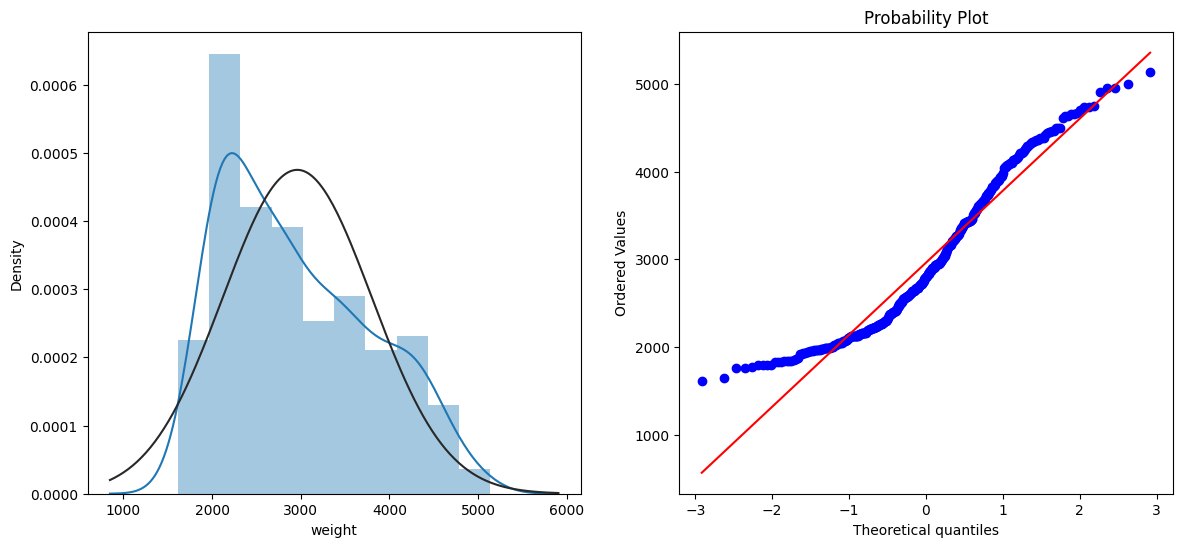

In [41]:
# distplot:                                                  # probability plot:
# blue line is current distribution                          # blue points is current distribution 
# black line is the desired normal distribution              # red line is the desired normal distribution 

for i in df_skewed.columns:
    (mu, sigma) = norm.fit(df[i])
    print(f"{i}: \nmu(mean): {mu}, \nsigma(std): {sigma}")
    plt.figure(figsize = (14,6))
    plt.subplot(121)
    sns.distplot(df[i], fit = norm)
    plt.subplot(122)
    stats.probplot(df[i], plot = plt)
    plt.show()

In [42]:
df_skewed.columns

Index(['mpg', 'displacement', 'horsepower', 'weight'], dtype='object')

In [43]:
 # Logarithmic Transformation

skewed_log = np.log(df[['mpg', 'displacement', 'horsepower', 'weight']])          

# skewed_log = np.sqrt(df[['mpg', 'displacement', 'horsepower', 'weight']])       ----> Square Root Transformation

# from scipy.stats import boxcox
# skewed_boxcox, _ = boxcox(df[['mpg', 'displacement', 'horsepower', 'weight']])   ---->  Box-Cox Transformation

skewed_log

,mpg,displacement,horsepower,weight
0,2.890372,5.726848,4.867534,8.161660
1,2.708050,5.857933,5.105945,8.214194
2,2.890372,5.762051,5.010635,8.142063
3,2.772589,5.717028,5.010635,8.141190
4,2.833213,5.710427,4.941642,8.145840
...,...,...,...,...
392,3.295837,5.017280,4.499810,7.989560
393,3.295837,4.941642,4.454347,7.933797
395,3.465736,4.905275,4.430817,7.738488
396,3.332205,4.787492,4.369448,7.872836


In [44]:
skewed = skewed_log.apply(lambda x: pd.Series.skew(x)).sort_values(ascending=False)
skewness = pd.DataFrame(skewed, columns=["skewed"])
skewness

,skewed
horsepower,0.361582
displacement,0.217831
weight,0.157425
mpg,-0.162109


* we can observe that the skewed values decrease with logarithmic transformation 

In [45]:
skewed_boxcox = df[['mpg', 'displacement', 'horsepower', 'weight']].apply(lambda x: boxcox(x)[0])
skewed_boxcox

,mpg,displacement,horsepower,weight
0,4.148375,2.732011,1.925802,2.828580
1,3.794790,2.754996,1.949229,2.832117
2,4.148375,2.738273,1.940174,2.827245
3,3.918213,2.730252,1.940174,2.827185
4,4.035880,2.729067,1.933365,2.827503
...,...,...,...,...
392,4.991595,2.590576,1.884166,2.816554
393,4.991595,2.573643,1.878505,2.812508
395,5.369690,2.565363,1.875528,2.797739
396,5.071254,2.537918,1.867609,2.808000


In [46]:
skewed = skewed_boxcox.apply(lambda x: pd.Series.skew(x)).sort_values(ascending=False)
skewness = pd.DataFrame(skewed, columns=["skewed"])
skewness

,skewed
displacement,0.073396
weight,0.034236
horsepower,0.026288
mpg,-0.022212


* we can observe that the boxcox transformation reduces the skewed values more than the logarithmic transformation

mpg: 
mu(mean): 4.606392763795278, 
sigma(std): 0.6960799453246593


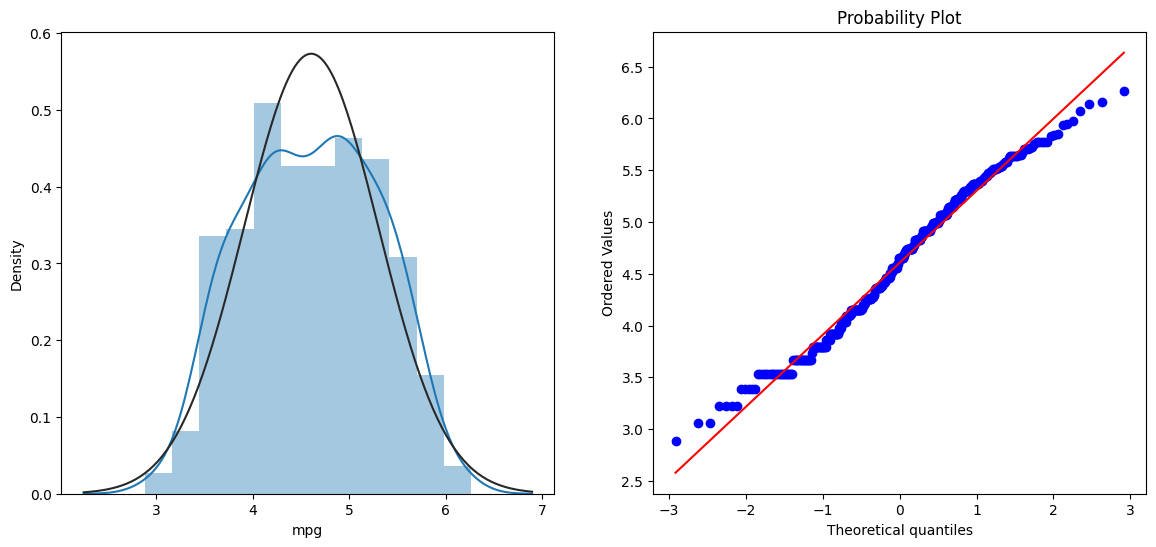

displacement: 
mu(mean): 2.6034534897501973, 
sigma(std): 0.11172294066066797


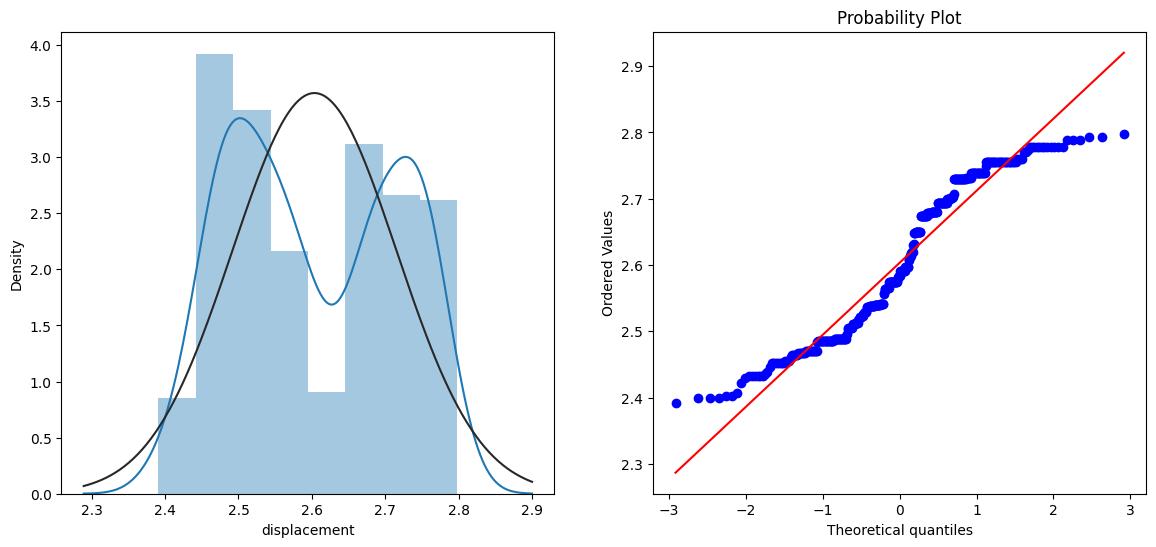

horsepower: 
mu(mean): 1.8909885964543802, 
sigma(std): 0.03857655750427772


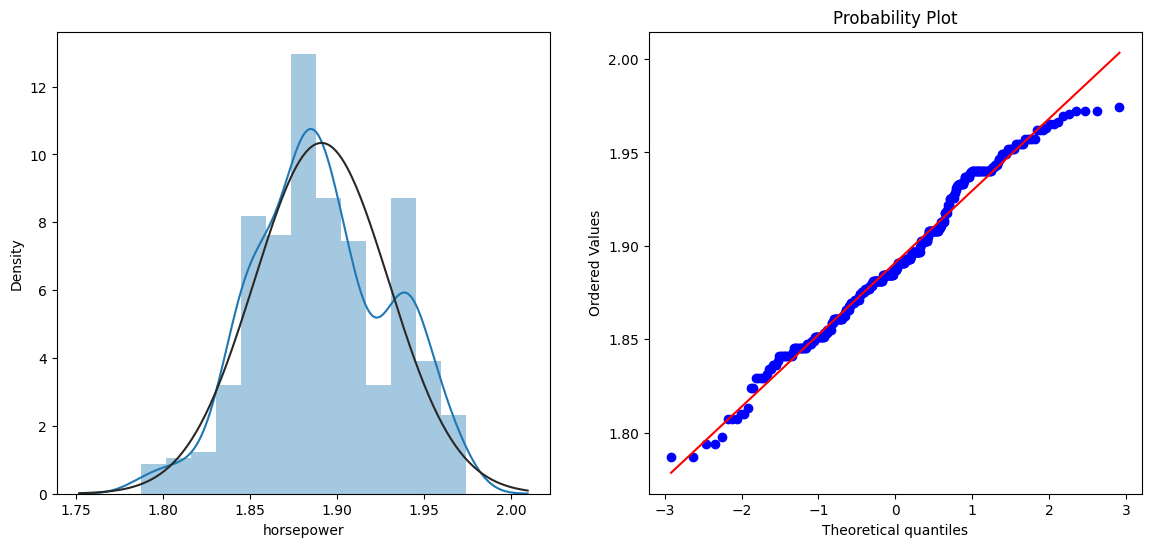

weight: 
mu(mean): 2.8130598914719775, 
sigma(std): 0.020227721331086197


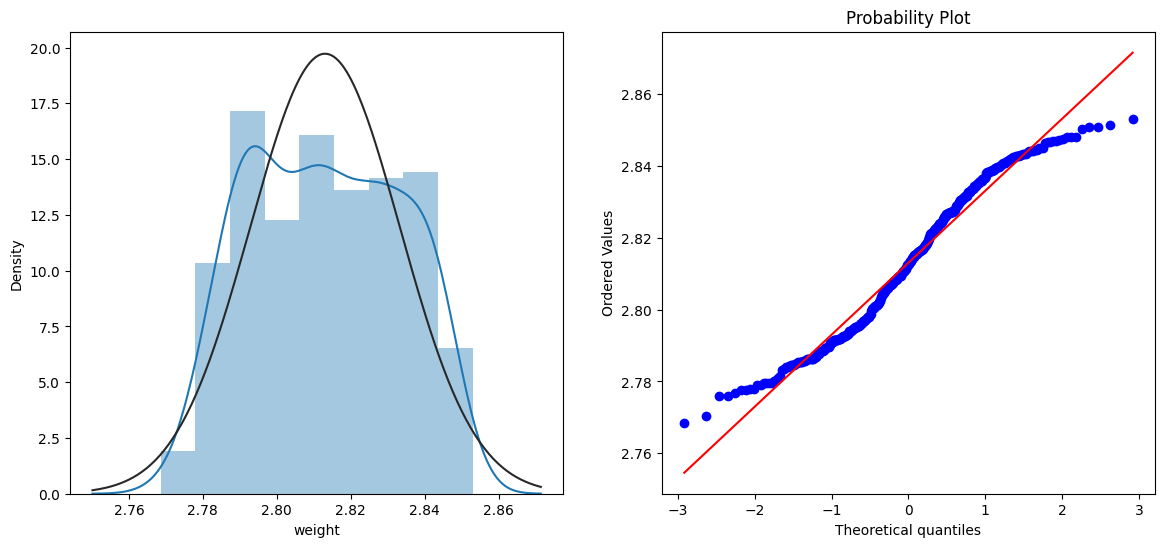

In [47]:
for i in skewed_boxcox.columns:
    (mu, sigma) = norm.fit(skewed_boxcox[i])
    print(f"{i}: \nmu(mean): {mu}, \nsigma(std): {sigma}")
    plt.figure(figsize = (14,6))
    plt.subplot(121)
    sns.distplot(skewed_boxcox[i], fit = norm)
    plt.subplot(122)
    stats.probplot(skewed_boxcox[i], plot = plt)
    plt.show()

* From the above output, we can observe the approximation to the normal distribution after skewness analysis

In [48]:
df_log = df.copy()
df_boxcox = df.copy()

In [49]:
# logarithmically transformed dataframe

df_log[['mpg', 'displacement', 'horsepower', 'weight']] = skewed_log[['mpg', 'displacement', 'horsepower', 'weight']]

df_log.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,2.890372,8,5.726848,4.867534,8.161660,12.0,70,1,chevrolet chevelle malibu
1,2.708050,8,5.857933,5.105945,8.214194,11.5,70,1,buick skylark 320
2,2.890372,8,5.762051,5.010635,8.142063,11.0,70,1,plymouth satellite
3,2.772589,8,5.717028,5.010635,8.141190,12.0,70,1,amc rebel sst
4,2.833213,8,5.710427,4.941642,8.145840,10.5,70,1,ford torino


In [50]:
# Box-Cox transformed dataframe

df_boxcox[['mpg', 'displacement', 'horsepower', 'weight']] = skewed_boxcox[['mpg', 'displacement', 'horsepower', 'weight']]

df_boxcox.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,4.148375,8,2.732011,1.925802,2.828580,12.0,70,1,chevrolet chevelle malibu
1,3.794790,8,2.754996,1.949229,2.832117,11.5,70,1,buick skylark 320
2,4.148375,8,2.738273,1.940174,2.827245,11.0,70,1,plymouth satellite
3,3.918213,8,2.730252,1.940174,2.827185,12.0,70,1,amc rebel sst
4,4.035880,8,2.729067,1.933365,2.827503,10.5,70,1,ford torino


# Transformation of Categorical Features

In [51]:
# logarithmically transformed dataframe
# Let's make columns whose type is numeric but categorical in nature categorical column

df_log["cylinders"] = df_log["cylinders"].astype(str)
df_log["origin"] = df_log["origin"].astype(str)

# One-Hot encoding 

selected_columns = ['cylinders', 'origin']
df_log = pd.get_dummies(df_log, columns=selected_columns)
df_log.head(2)

,mpg,displacement,horsepower,weight,acceleration,model year,car name,cylinders_3,cylinders_4,cylinders_5,cylinders_6,cylinders_8,origin_1,origin_2,origin_3
0,2.890372,5.726848,4.867534,8.161660,12.0,70,chevrolet chevelle malibu,0,0,0,0,1,1,0,0
1,2.708050,5.857933,5.105945,8.214194,11.5,70,buick skylark 320,0,0,0,0,1,1,0,0


In [52]:
# Box-Cox transformed dataframe
# Let's make columns whose type is numeric but categorical in nature categorical column

df_boxcox["cylinders"] = df_boxcox["cylinders"].astype(str)
df_boxcox["origin"] = df_boxcox["origin"].astype(str)

# One-Hot encoding 

selected_columns = ['cylinders', 'origin']
df_boxcox = pd.get_dummies(df_boxcox, columns=selected_columns)
df_boxcox.head(2)

,mpg,displacement,horsepower,weight,acceleration,model year,car name,cylinders_3,cylinders_4,cylinders_5,cylinders_6,cylinders_8,origin_1,origin_2,origin_3
0,4.148375,2.732011,1.925802,2.828580,12.0,70,chevrolet chevelle malibu,0,0,0,0,1,1,0,0
1,3.794790,2.754996,1.949229,2.832117,11.5,70,buick skylark 320,0,0,0,0,1,1,0,0


# Train-Test Split & Standardization

* If you are working with data that contains outliers and you do not want these outliers to have a significant impact on scaling, RobustScaler can be preferred. In general, if the data needs to be transformed to a standard normal distribution or if direct comparison between features is required, StandardScaler can be preferred.
* Let's make train-test split with both standard scaler and robust scaler 

In [53]:
def split_standard(df, test_size=0.2, random_state=42):
    x = df.drop(["mpg","car name"], axis = 1)  
    y = df.mpg
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)
    
    scaler = StandardScaler()                    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

In [54]:
def split_robust(df, test_size=0.2, random_state=42):
    x = df.drop(["mpg","car name"], axis = 1)  
    y = df.mpg
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)
    
    scaler = RobustScaler()                    

    X_train_robust = scaler.fit_transform(X_train)
    X_test_robust = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

# Modelling

### LinearRegression, Ridge, Lasso, ElasticNet

In [55]:
def train_models(X_train, X_test, y_train, y_test):
    model_name = []
    model_mae = []
    model_mse = []

    # Linear Regression
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    y_pred_lin = lin_reg.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred_lin)
    mse = mean_squared_error(y_test, y_pred_lin)
    model_name.append("Linear")
    model_mae.append(mae)
    model_mse.append(mse)

    # Ridge
    ridge = Ridge(random_state=42, max_iter=10000)
    alphas = np.logspace(-4, -0.5, 30)
    tuned_parameters = [{'alpha': alphas}]
    n_folds = 5

    clf = GridSearchCV(ridge, tuned_parameters, cv=n_folds, scoring="neg_mean_squared_error", refit=True)
    clf.fit(X_train, y_train)
    y_pred_ridge = clf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_ridge)
    mae = mean_absolute_error(y_test, y_pred_ridge)
    model_name.append("Ridge")
    model_mae.append(mae)
    model_mse.append(mse)

    # Lasso
    lasso = Lasso(random_state=42, max_iter=10000)
    clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, scoring='neg_mean_squared_error', refit=True)
    clf.fit(X_train, y_train)
    y_pred_lasso = clf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_lasso)
    mae = mean_absolute_error(y_test, y_pred_lasso)
    model_name.append("Lasso")
    model_mae.append(mae)
    model_mse.append(mse)

    # ElasticNet
    parametersGrid = {"alpha": alphas, "l1_ratio": np.arange(0.0, 1.0, 0.05)}
    eNet = ElasticNet(random_state=42, max_iter=10000)
    clf = GridSearchCV(eNet, parametersGrid, cv=n_folds, scoring='neg_mean_squared_error', refit=True)
    clf.fit(X_train, y_train)
    y_pred_elastic = clf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_elastic)
    mae = mean_absolute_error(y_test, y_pred_elastic)
    model_name.append("ElasticNet")
    model_mae.append(mae)
    model_mse.append(mse)

    final = pd.DataFrame({"Model": model_name, "MAE": model_mae, "MSE": model_mse})
    final.sort_values(by="MAE", inplace=True)
    
    return final

* **MAE** measures the average of the absolute differences between actual fuel consumption values and those predicted by the model. This metric helps you assess how far the predicted fuel consumption values are from the actual values. A lower MAE indicates a better model performance.
* **MSE** measures the average of the squared differences between actual fuel consumption values and those predicted by the model. MSE further emphasizes the magnitude of errors and is a metric where large errors have more weight.
* Which metric we prefer depends on what is more important for fuel prediction in your data set. If we care about the magnitude of the errors, we can use MSE. However, MAE is considered a more balanced metric and focuses on the absolute values of the errors. Therefore, it is often one of the preferred metrics.

In [56]:
# df_log + standardscaler
X_train, X_test, y_train, y_test = split_standard(df_log)
train_models(X_train, X_test, y_train, y_test)

,Model,MAE,MSE
3,ElasticNet,0.085623,0.013610
2,Lasso,0.085738,0.013653
1,Ridge,0.085806,0.013571
0,Linear,0.085835,0.013574


In [57]:
# df_log + robustscaler
X_train, X_test, y_train, y_test = split_robust(df_log)
train_models(X_train, X_test, y_train, y_test)

,Model,MAE,MSE
0,Linear,0.085835,0.013574
1,Ridge,0.086141,0.013698
3,ElasticNet,0.086186,0.013809
2,Lasso,0.086204,0.013823


In [58]:
# df_boxcox + standardscaler
X_train, X_test, y_train, y_test = split_standard(df_boxcox)
train_models(X_train, X_test, y_train, y_test)

,Model,MAE,MSE
3,ElasticNet,0.183580,0.063105
1,Ridge,0.183713,0.062861
0,Linear,0.183731,0.062884
2,Lasso,0.183864,0.063157


In [59]:
# df_boxcox + robustscaler
X_train, X_test, y_train, y_test = split_robust(df_boxcox)
train_models(X_train, X_test, y_train, y_test)

,Model,MAE,MSE
0,Linear,0.183731,0.062884
1,Ridge,0.183764,0.062871
2,Lasso,0.184817,0.063418
3,ElasticNet,0.185636,0.063471


* The difference between the two metrics is the use of the squares of the errors. While MSE gives more weight to large errors, MAE uses the absolute values of the errors and is considered a more balancing metric.

* If we compare with MAE metric, the best result was with the **ElasticNet** model over the dataframe we made **Logarithmic Transformation** and **StandardScaler**

### let's compare the best model prediction with real mpg values

In [60]:
X_train, X_test, y_train, y_test = split_standard(df_log)
alphas = np.logspace(-4, -0.5, 30)
parametersGrid = {"alpha": alphas, "l1_ratio": np.arange(0.0, 1.0, 0.05)}
eNet = ElasticNet(random_state=42, max_iter=10000)
clf = GridSearchCV(eNet, parametersGrid, cv=5, scoring='neg_mean_squared_error', refit=True)
clf.fit(X_train, y_train)
y_pred_elastic = clf.predict(X_test)

In [61]:
y_test.shape

(79,)

In [62]:
# Let's take the inverse of the log transformation we applied at the beginning
original_y_test = np.exp(y_test)
original_y_pred_elastic = np.exp(y_pred_elastic)

In [63]:
predictions_df = pd.DataFrame({"Real_mpg": original_y_test, "Predict_mpg": original_y_pred_elastic})
predictions_df

,Real_mpg,Predict_mpg
10,15.0,13.941225
44,13.0,11.761734
35,17.0,16.735358
317,34.3,32.185968
376,37.0,36.692720
...,...,...
3,16.0,14.485337
20,25.0,20.880087
97,18.0,17.905030
254,20.2,22.683064


## xgboost

In [64]:
import xgboost as xgb

In [65]:
# we have chosen the dataframe and standardization method that we got the best result from the above operations 
X_train, X_test, y_train, y_test = split_standard(df_log)

In [66]:
# Model creation
model_xgb = xgb.XGBRegressor()

# Define the ranges of hyperparameters
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 500, 1000]
}

# Specify the model and parameters for GridSearchCV
grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Training the model
grid_search.fit(X_train, y_train)

# Get the best parameters and scores
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters:", best_params)
print("Best score:", best_score)

# Select the best model
best_model = grid_search.best_estimator_

# Make predictions on the test dataset
y_predicted = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_predicted)
print("XGBRegressor MSE:", mse)

mae = mean_absolute_error(y_test, y_predicted)
print("XGBRegressor MAE: ", mae)

Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000}
Best score: -0.012915141584334568
XGBRegressor MSE: 0.011455897206137848
XGBRegressor MAE:  0.07716245135092556


In [67]:
# Let's compare xgboost model prediction with our actual target variable
original_y_test = np.exp(y_test)
original_y_pred_elastic = np.exp(y_predicted)

predictions_df = pd.DataFrame({"Real_mpg": original_y_test, "Predict_mpg": original_y_pred_elastic})
predictions_df

,Real_mpg,Predict_mpg
10,15.0,15.380518
44,13.0,12.122529
35,17.0,17.470194
317,34.3,34.910721
376,37.0,35.020630
...,...,...
3,16.0,15.418356
20,25.0,23.829493
97,18.0,18.175512
254,20.2,21.695736


* With the xgboost model, we made a better prediction than other models

* XGBRegressor MSE: 0.011455
* XGBRegressor MAE: 0.077162

* ElasticNet MSE:  0.013610
* ElasticNet MAE:  0.085623
